In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import copy
import time

In [3]:
DEVICE = "cuda:0"
DATA_PATH = "/mnt/ssd/ronak/datasets/"

In [4]:
def get_param_shapes(parameters):
    return [torch.tensor(p.shape) for p in parameters]

def get_num_parameters(param_shapes):
    return torch.tensor([torch.prod(s) for s in param_shapes]).sum().item()

def unflatten_gradient(g, param_shapes):
    chunks = list(torch.split(g, [torch.prod(s) for s in param_shapes]))
    for i, chunk in enumerate(chunks):
        chunks[i] = chunk.reshape(tuple(param_shapes[i]))
    return chunks

def flatten_parameters(parameters):
    return torch.cat([p.reshape(-1) for p in parameters])

class RecurrentNet(nn.Module):

    def __init__(self, vocab_size, n_classes):
        super().__init__()
        embed_dim = 64
        hidden_dim = 128
        nn.Embedding(vocab_size, embed_dim)
        self.lstm1 = nn.LSTM(embed_dim, hidden_dim, num_layers=1)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1)
        self.classifier = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        return self.classifier(self.lstm2(self.lstm1(x)))
    
class GradientModel(nn.Module):

    def __init__(self, n_model_params, n_score_params, hidden_size=512):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(n_model_params + n_score_params, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, n_model_params),
        )

    def forward(self, g, score):
        x = torch.cat([g, score], dim=1)
        return self.ffn(x)

In [12]:
def train_one_epoch_func(dataloader, func_model, func_optimizer):
    floss = 0.0
    for i, (x, y) in enumerate(dataloader):
        logits = func_model(x.to(DEVICE))
        loss = F.binary_cross_entropy_with_logits(logits, y.to(DEVICE))
        loss.backward()
        func_optimizer.step()
        func_optimizer.zero_grad()
        floss += loss.item() / len(dataloader)
    return floss

@torch.no_grad()
def evaluate_func(dataloader, func_model):
    floss = 0.0
    acc = 0.0
    for i, (x, y) in enumerate(dataloader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        logits = func_model(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        floss += loss.item() / len(dataloader)
        acc += torch.mean((y == torch.argmax(logits, dim=1)).float()).item() / len(dataloader)
    return floss, acc

def train_one_epoch_grad(dataloader, func_model, grad_model, grad_optimizer):
    gloss = 0.0
    param = flatten_parameters(func_model.parameters()).clone()
    param_shapes = get_param_shapes(func_model.parameters())
    for i, (x, y) in enumerate(dataloader):

        noise = 0.5 * param.std() * torch.randn(size=param.shape).to(DEVICE)
        noise_list = unflatten_gradient(noise, param_shapes)
        for i, p in enumerate(func_model.parameters()):
            p += noise_list[i]

        logits = func_model(x.to(DEVICE))
        loss = F.cross_entropy(logits, y.to(DEVICE))
        grads = torch.autograd.grad(outputs=loss, inputs=func_model.parameters())

        targets_true = flatten_parameters(grads).to(DEVICE)
        targets_pred = grad_model(x.to(DEVICE), y.to(DEVICE), param + noise)
        error = F.mse_loss(targets_pred, targets_true)
        error.backward()

        grad_optimizer.step()
        grad_optimizer.zero_grad()
        gloss += error.item() / len(dataloader)
    return gloss

def evaluate_grad(dataloader, func_model, grad_model):
    gloss = 0.0
    param = flatten_parameters(func_model.parameters()).clone()
    for i, (x, y) in enumerate(dataloader):
        logits = func_model(x.to(DEVICE))
        loss = F.cross_entropy(logits, y.to(DEVICE))
        grads = torch.autograd.grad(outputs=loss, inputs=func_model.parameters())
        targets_true = flatten_parameters(grads).to(DEVICE)
        with torch.no_grad():
            targets_pred = grad_model(x.to(DEVICE), y.to(DEVICE), param)
            error = F.mse_loss(targets_pred, targets_true)
        gloss += error.item() / len(dataloader)
    return gloss

### Train Gradient Model on FashionMNIST

In [13]:
root = os.path.join(DATA_PATH, "fashion_mnist")
train_set = FashionMNIST(root, download=True)
mean = train_set.data.float().mean(dim=0)
std = train_set.data.float().std(dim=0)

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ])

# reload datasets
train_set = FashionMNIST(root, download=True, transform=transform)
val_set = FashionMNIST(root, download=True, transform=transform, train=False)

n_epochs = 10
batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [14]:
height, width, n_classes = 28, 28, 10

func_model = ConvNet(height, width, n_classes).to(DEVICE)
param_shapes = get_param_shapes(func_model.parameters())
n_parameters = get_num_parameters(param_shapes)
grad_model = GradientModel(height, width, n_classes, n_parameters, hidden_size=64).to(DEVICE)

func_optimizer = torch.optim.Adam(func_model.parameters(), lr=1e-3)
grad_optimizer = torch.optim.Adam(grad_model.parameters(), lr=1e-4)

In [15]:
func_train_loss = torch.zeros(n_epochs)
grad_train_loss = torch.zeros(n_epochs)
func_val_acc    = torch.zeros(n_epochs)
grad_val_loss   = torch.zeros(n_epochs)

torch.manual_seed(123)
for epoch in range(n_epochs):
    # train the function model for one epoch to learn the parameters
    func_train_loss[epoch] = train_one_epoch_func(train_loader, func_model, func_optimizer)
    print(f"func train loss epoch {epoch:02d}: {func_train_loss[epoch]:0.5f}")
    _, func_val_acc[epoch] = evaluate_func(val_loader, func_model)
    print(f"func valid acc epoch {epoch:02d}:  {func_val_acc[epoch]:0.5f}")

    # train the gradient model for one epoch
    grad_train_loss[epoch] = train_one_epoch_grad(train_loader, func_model, grad_model, grad_optimizer)
    print(f"grad train loss epoch {epoch:02d}: {grad_train_loss[epoch]:0.5f}")
    grad_val_loss[epoch] = evaluate_grad(val_loader, func_model, grad_model)
    print(f"grad valid loss epoch {epoch:02d}: {grad_val_loss[epoch]:0.5f}")
    print()

func train loss epoch 00: 9.83735
func valid acc epoch 00:  0.20856


RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

Text(0, 0.5, 'Validation Loss')

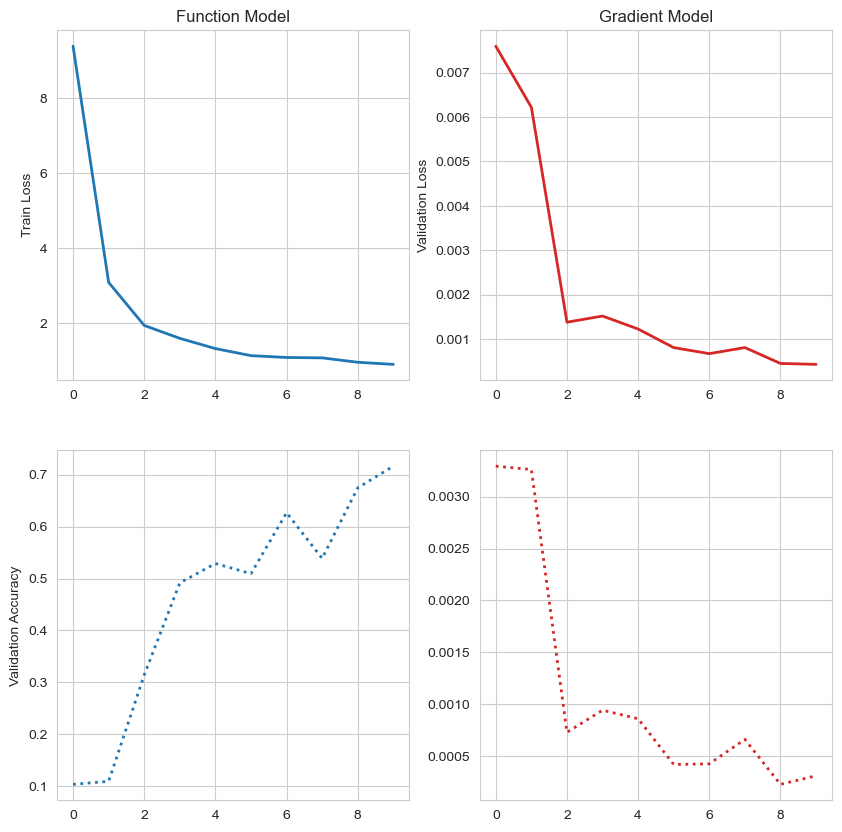

In [ ]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

t = np.arange(n_epochs)

axes[0, 0].plot(t, func_train_loss, color="tab:blue", linewidth=2, linestyle="solid")
axes[0, 1].plot(t, grad_train_loss, color="tab:red", linewidth=2, linestyle="solid")
axes[1, 0].plot(t, func_val_acc, color="tab:blue", linewidth=2, linestyle="dotted")
axes[1, 1].plot(t, grad_val_loss, color="tab:red", linewidth=2, linestyle="dotted")

axes[0, 0].set_title("Function Model")
axes[0, 1].set_title("Gradient Model")

axes[0, 0].set_ylabel("Train Loss")
axes[0, 1].set_ylabel("Train Loss")
axes[1, 0].set_ylabel("Validation Accuracy")
axes[0, 1].set_ylabel("Validation Loss")

### Train Model on Related Dataset with No Backpropagation

In [ ]:
root = os.path.join(DATA_PATH, "mnist")
train_set = MNIST(root, download=True)
mean = train_set.data.float().mean(dim=0)
std = train_set.data.float().std(dim=0)
std[std < 1e-8] = 1.0
print(std.shape)
print(train_set.data.shape)

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ])

# reload datasets
train_set = MNIST(root, download=True, transform=transform)
val_set = MNIST(root, download=True, transform=transform, train=False)

n_epochs = 10
batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

torch.Size([28, 28])
torch.Size([60000, 28, 28])


In [115]:
DEVICE = "cuda:2"
height, width, n_classes = 28, 28, 10
model = ConvNet(height, width, n_classes).to(DEVICE)
gmodel = copy.deepcopy(grad_model).to(DEVICE)
goptimizer = torch.optim.Adam(gmodel.parameters(), lr=1e-3)

In [116]:
lr = 0.0001
mu = 0.5
param_shapes = get_param_shapes(model.parameters())

with torch.no_grad():

    train_loss = torch.zeros(n_epochs)
    train_acc  = torch.zeros(n_epochs)
    val_loss   = torch.zeros(n_epochs)
    val_acc    = torch.zeros(n_epochs)

    torch.manual_seed(123)

    total_time = 0.0
    momentum = torch.zeros(torch.tensor([torch.prod(s) for s in param_shapes]).sum()).to(DEVICE)
    print(momentum.shape)
    for epoch in range(n_epochs):
        tic = time.time()

        if epoch % 5 == 0:
            print(f"epoch {epoch}: refitting gradient model...")
            with torch.enable_grad():
                gloss = train_one_epoch_grad(train_loader, model, gmodel, goptimizer)
            print(f"epoch {epoch}: {gloss:0.6f} grad loss")

        for x, y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            param = flatten_parameters(model.parameters())
            grad = gmodel(x.to(DEVICE), y.to(DEVICE), param)

            if mu > 0.0:
                param -= lr * (grad + mu * momentum)
            else:
                param -= lr * grad
            new_param = unflatten_gradient(param, param_shapes)
            for i, p in enumerate(model.parameters()):
                p.copy_(new_param[i])
            if mu > 0.0:
                momentum = grad
        toc = time.time()
        total_time += (toc - tic)

        train_loss[epoch], train_acc[epoch] = evaluate_func(train_loader, model)
        val_loss[epoch], val_acc[epoch] = evaluate_func(val_loader, model)

        print(f"train loss: {train_loss[epoch]:0.5f}")
        print(f"train acc:  {train_acc[epoch]:0.5f}")
        print(f"valid loss: {val_loss[epoch]:0.5f}")
        print(f"valid acc:  {val_acc[epoch]:0.5f}")
        print()


print(total_time)
print(train_loss[-10:])
print(train_acc[-10:])
print(val_loss[-10:])
print(val_acc[-10:])

torch.Size([1078410])
epoch 0: refitting gradient model...
epoch 0: 0.000569 grad loss
train loss: 151.47705
train acc:  0.10000
valid loss: 151.80812
valid acc:  0.09958

train loss: 280.01990
train acc:  0.10001
valid loss: 280.10834
valid acc:  0.09958



KeyboardInterrupt: 